In [10]:
import warnings
warnings.filterwarnings('ignore')

# import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
from gensim import corpora, models

# import spacy
from spacy.lang.id import Indonesian
nlp = Indonesian()  # use directly
stopwords = spacy.lang.id.stop_words.STOP_WORDS 
stopwords |= {"nya","jurusan","jurus"}

from json import loads
from ast import literal_eval
from pickle import dump,load

from gensim.models.coherencemodel import CoherenceModel
#show graphs
import matplotlib.pyplot as plt
from gensim import similarities

import pyLDAvis.gensim

In [2]:
# #Akronim
def slang(tokenized_sentence):
    slang_word_dict = loads(open("slang_word_dict.txt", 'r').read())

    for index in range(len(tokenized_sentence)):
        for key, value in slang_word_dict.items():
            for v in value:
                if tokenized_sentence[index] == v:
                    tokenized_sentence[index] = key
                else:
                    continue
                    
    return " ".join(tokenized_sentence)

def preprocessing(text):
    text = re.sub('<[^<]+?>', '', str(text)) #remove tag\n",
    text = text.lower() #lower\n",
    text = re.sub(r'[^\w]',' ',str(text)) #remove punct\n",
    text = re.sub(r'\s+', ' ', text) #remove white space\n",
    text = [token.text for token in nlp(text)] #Token
    text = slang(text)#slang word
    text = [token.lemma_ for token in nlp(text) if token.lemma_ not in stopwords] #Lemma & stopword
    
    return text

#function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=500)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [3]:
#Load Clean data
data = pd.read_csv('data_berita_clean.csv')

#Make list of list
mylist = []

for i,j in data.iterrows():
    tmp = literal_eval(j.content)
    mylist.append(tmp)
    
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(mylist, min_count=10)
for idx in range(len(mylist)):
    for token in bigram[mylist[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            mylist[idx].append(token)
    
# Create Dictionary
dictionary = corpora.Dictionary(mylist)

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in mylist]

dump(corpus, open('corpus_LDA.pkl', 'wb'))
dictionary.save('dictionary_LDA.gensim')

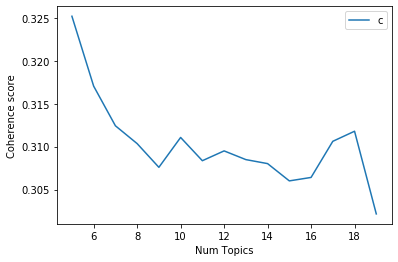

In [6]:
#search optimal topic number (5)
start=5
limit=20
step=1
model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus, 
                                                        texts=mylist, start=start, limit=limit, step=step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [7]:
# Build LDA model
NUM_TOPICS = 5
lda_model = LdaModel(corpus=corpus,
                    id2word=dictionary,
                    num_topics=NUM_TOPICS, 
                    random_state=666)

#Save Model
lda_model.save('lda.h5')

In [32]:
#Load Mode
loaded_model = LdaModel.load('lda.h5')
test = pd.read_csv('data_berita.csv')
file = open('corpus_LDA.pkl','rb')
loaded_corpus = load(file)

#Test new document
bow = dictionary.doc2bow(preprocessing(test.content.values[658]))
 
print(loaded_model[bow])
 
lda_index = similarities.MatrixSimilarity(loaded_model[loaded_corpus])
 
# # Let's perform some queries
query = lda_index[loaded_model[bow]]
# # Sort the similarities
sort_sim = sorted(enumerate(query), key=lambda item: -item[1])
 
# # Top most similar documents:
print(sort_sim[:10])

# # Let's see what's the most similar document
# document_id, similarity = sort_sim
# print(mylist[document_id][:10])

[(0, 0.026724733), (2, 0.29203472), (3, 0.44528833), (4, 0.22925079)]
[(52, 0.99839056), (292, 0.9762201), (476, 0.9746133), (478, 0.96526605), (204, 0.9496614), (51, 0.9372455), (101, 0.92738587), (581, 0.92435235), (350, 0.9240174), (280, 0.9114827)]


In [12]:
# Print the Keyword in the 10 topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.007*"kuliah" + 0.007*"ajar" + 0.006*"universitas" + 0.006*"teknik" + 0.005*"kerja"')
(1, '0.009*"ajar" + 0.008*"teknik" + 0.007*"orang" + 0.007*"mahasiswa" + 0.006*"sobat"')
(2, '0.014*"orang" + 0.011*"ajar" + 0.009*"kerja" + 0.008*"bahasa" + 0.007*"kuliah"')
(3, '0.011*"universitas" + 0.010*"ajar" + 0.008*"ilmu" + 0.008*"kuliah" + 0.007*"orang"')
(4, '0.015*"orang" + 0.008*"kuliah" + 0.007*"ajar" + 0.006*"milik" + 0.006*"kerja"')


In [11]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.008932 -0.006861       1        1  29.141224
4     -0.011806  0.003218       2        1  22.969463
1     -0.002836  0.011813       3        1  20.851738
3      0.006684 -0.014522       4        1  15.257721
0      0.016891  0.006351       5        1  11.779855, topic_info=     Category         Freq         Term        Total  loglift  logprob
107   Default  1380.000000  universitas  1380.000000  30.0000  30.0000
114   Default   273.000000          000   273.000000  29.0000  29.0000
939   Default  1320.000000         ilmu  1320.000000  28.0000  28.0000
452   Default   582.000000          uji   582.000000  27.0000  27.0000
214   Default  1692.000000       kuliah  1692.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
11     Topic5    81.651154       bahasa  1015.270020  -0.3817  -5.8586
83     Topic5    79.761284        salah   910.892029  -0.2966  -5.8821
1072   Topic5    74.012238          the   734.302979  -0.1559  -5.9569
162    Topic5    73.256653         beda   621.033264   0.0014  -5.9671
462    Topic5    73.397964           ya   751.513672  -0.1874  -5.9652

[461 rows x 6 columns], token_table=      Topic      Freq Term
term                      
113       1  0.063008   00
113       2  0.178522   00
113       3  0.446306   00
113       4  0.047256   00
113       5  0.262533   00
...     ...       ...  ...
4207      1  0.271368    z
4207      2  0.079814    z
4207      3  0.111740    z
4207      4  0.111740    z
4207      5  0.430997    z

[1250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])